# This is an example notebook to show how our code can be used for a growth-based scenario modelling

## Imports

We first import the required modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from SuSceMod.simulation import logger, data_utilities, input_handling, scenarios

## Setup of the simulation

Need to first add the paths to the input and output folders

In [2]:
parent_folder = '.'
input_folder = './input_rasters/'

output_folder = './output_growth_based/'
os.makedirs(output_folder, exist_ok=True)

suitability_maps_folder = './suitability_maps/'

In [3]:
initial_year = 2020
final_year = 2030

In [4]:
prob_years = [2010, 2020]
change_years = [2010, 2020]

In [5]:
initial_built_up_map = data_utilities.load_raster_data(
    input_folder + f'BU_{initial_year}.tif'
) 

Path to the suitability maps must be added, to guide the allocation. These can be outputs of ML models likes MultiNomial Logistic regression in our case 

In [6]:
suitability_maps_path = suitability_maps_folder + f"{str(prob_years[0])[-2:]}_{str(prob_years[1])[-2:]}/"
prob_maps_dict, prob_map_paths = input_handling.load_prob_maps(suitability_maps_path, prob_years)

Give the paths to the maps to calculate the change maps, and in turn, the demand

In [7]:
initial_demand_map = input_folder + f'BU_{change_years[0]}.tif'
final_demand_map   = input_folder + f'BU_{change_years[1]}.tif'

change_maps_dict, classes = input_handling.calculate_change_maps(
    initial_demand_map, final_demand_map
)

In [8]:
annual_rates, period_counts, crosstab_df = input_handling.calculate_change_rates(
    change_maps_dict, change_years
)


Crosstab (counts, incl. no-change on diagonal):
         0      1       2      3
0  1381843   4906    3538    744
1        0  72337    5613    202
2        0      0  159056   3665
3        0      0       0  58216

Annual change rates (cells/year):
    -> 0 → 1: 490.6
    -> 0 → 2: 353.8
    -> 0 → 3: 74.4
    -> 1 → 2: 561.3
    -> 1 → 3: 20.2
    -> 2 → 3: 366.5


## Running the simulation

In [9]:
simulated_maps, output_paths, class_counts_dict = scenarios.simulate_growth_based_scenario(
    initial_year,
    final_year,
    initial_built_up_map, 
    prob_maps_dict,
    change_years,
    annual_rates,
    output_folder,
    parent_folder,
    randomness='gumbel',
    seed=2118
)


Demands (cells/year):
    -> 0 → 1: 490.6
    -> 0 → 2: 353.8
    -> 0 → 3: 74.4
    -> 1 → 2: 561.3
    -> 1 → 3: 20.2
    -> 2 → 3: 366.5

###################################################################

Current year: 2020
Simulating for year: 2021


D:\Codes\Scripts_CA\CA_MCMC\TO UPLOAD\Sept_2025\SuSceMod\SuSceMod\simulation\core_functions.py:14: RuntimeWarning: invalid value encountered in cast
  a = built_up_map.astype(np.int32, copy=False)
D:\Codes\Scripts_CA\CA_MCMC\TO UPLOAD\Sept_2025\SuSceMod\SuSceMod\simulation\core_functions.py:61: RuntimeWarning: invalid value encountered in cast
  donor_mask = (valid & (a.astype(np.int32) == i))
D:\Codes\Scripts_CA\CA_MCMC\TO UPLOAD\Sept_2025\SuSceMod\SuSceMod\simulation\core_functions.py:108: RuntimeWarning: invalid value encountered in cast
  a_int = a.astype(np.int32, copy=False)



------------------------------------------------------

Year 2021: Updated built-up map summary (value: count):
{0.0: 1380924, 1.0: 77153, 2.0: 168756, 3.0: 63287, 'nan': 2004749}

###################################################################

Current year: 2021
Simulating for year: 2022

------------------------------------------------------

Year 2022: Updated built-up map summary (value: count):
{0.0: 1380005, 1.0: 77063, 2.0: 169305, 3.0: 63747, 'nan': 2004749}

Changes from previous year summary (value: count):
{0: -919, 1: -90, 2: 549, 3: 460}

###################################################################

Current year: 2022
Simulating for year: 2023

------------------------------------------------------

Year 2023: Updated built-up map summary (value: count):
{0.0: 1379086, 1.0: 76973, 2.0: 169854, 3.0: 64207, 'nan': 2004749}

Changes from previous year summary (value: count):
{0: -919, 1: -90, 2: 549, 3: 460}

######################################################

In [10]:
counts_csv_file = os.path.join(output_folder, f"class_counts_{initial_year}_{final_year}.csv")
data_utilities.save_counts_to_csv(class_counts_dict, counts_csv_file)

A template raster is required to save the simulated rasters with proper extent and boundaries. We can simply use the `initial_built_up_map` for this purpose

In [11]:
template_raster_path = input_folder + f'BU_{change_years[0]}.tif'

In [12]:
for year in simulated_maps.keys():
    data_utilities.writeraster(template_raster_path, output_paths[year], simulated_maps[year])

## View results of the simulation

### Understanding the trend of each density class over time

Convert the class counts dictionary `class_counts_dict` to a dataframe for easier processing

In [13]:
class_counts_df = data_utilities.counts_to_df(class_counts_dict, exclude_nan=True)

We can now filter to get the required values. Here, for example, we look at the year 2025

In [14]:
class_counts_df[class_counts_df['year']==2025]

,year,category,count
16,2025,0.0,1377248
17,2025,1.0,76793
18,2025,2.0,170952
19,2025,3.0,65127


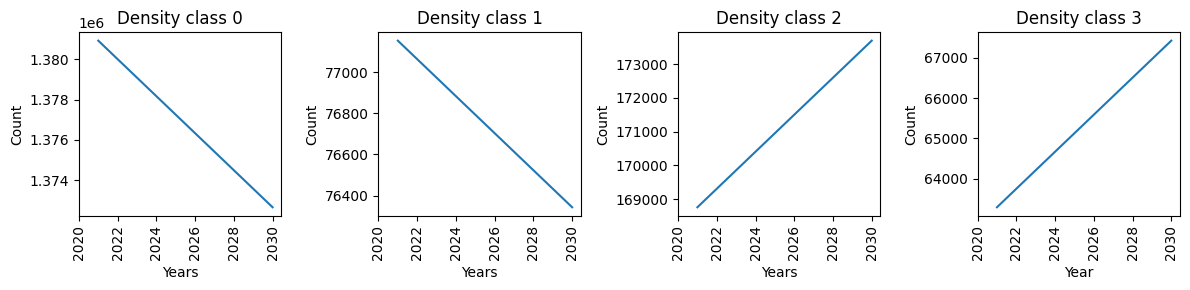

In [15]:
categories = class_counts_df["category"].unique()
n = len(categories)

fig, axes = plt.subplots(1, n, figsize=(12, 3), sharex=True)

for ax, cat in zip(axes, categories):
    sub = class_counts_df[class_counts_df["category"] == cat]
    ax.plot(sub["year"], sub["count"])
    ax.set_title(f"Density class {int(cat)}")
    ax.set_ylabel("Count")
    ax.set_xlabel("Years")
    ax.tick_params(axis="x", labelrotation=90)
    years = range(initial_year, final_year+1, 2)
    ax.set_xticks(years)

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


### Quick visualization of the simulated rasters

For example, we look at the density classes for the raster of year 2025

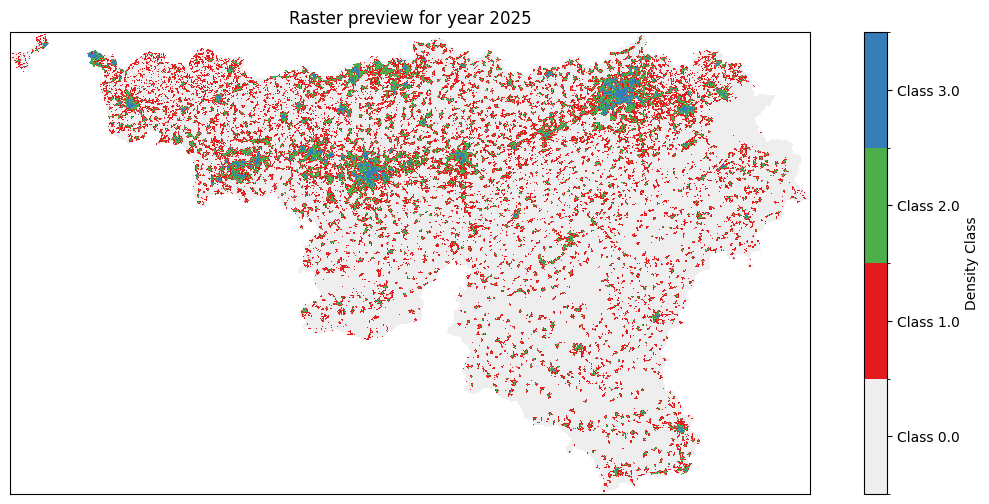

In [16]:
example_year = 2025

example_raster = data_utilities.load_raster_data(output_folder + f"sim_{example_year}.tif")
data_utilities.plot_raster_classes(
    example_raster, 
    colors=["#eeeeee", "#e41a1c", "#4daf4a", "#377eb8"], 
    title=f'Raster preview for year {example_year}'
)